In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import abc_load as abc

In [18]:
import nibabel
import anndata as ad
import numpy as np
import pandas as pd
import scipy.ndimage as ndi

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
%matplotlib inline

## walkthrough of abc.label_thalamus_spatial_subset()

In [4]:
field_name='TH_ZI_dataset'
# use reconstructed (in MERFISH space) coordinates from cells_df
coords = ['x_reconstructed','y_reconstructed','z_reconstructed']
resolutions = np.array([10e-3, 10e-3, 200e-3])

In [5]:
cells_df = abc.get_combined_metadata(drop_unused=False)

In [6]:
ccf_df = pd.read_csv(
        abc.ABC_ROOT/"metadata/Allen-CCF-2020/20230630/parcellation_to_parcellation_term_membership.csv"
        )

In [7]:
th_zi_ind = np.hstack(
        (ccf_df.loc[ccf_df['parcellation_term_acronym']=='TH', 
                    'parcellation_index'].unique(),
             ccf_df.loc[ccf_df['parcellation_term_acronym']=='ZI', 
                    'parcellation_index'].unique())
)
len(th_zi_ind)
# th_zi_ind

53

## resampled ccf (z resolution limited to merscope slices)

In [8]:
ccf_img = abc.get_ccf_labels_image(resampled=True)
ccf_img.shape

(1100, 1100, 76)

In [9]:
# takes about 5 sec
th_mask = np.isin(ccf_img, th_zi_ind)

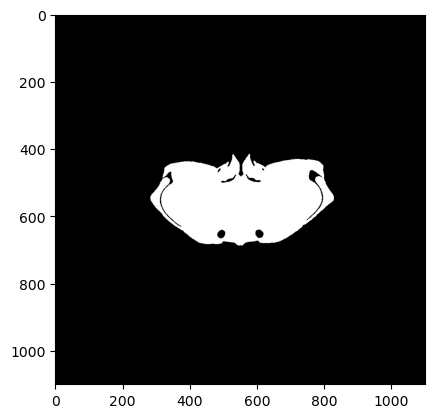

In [12]:
plt.imshow(th_mask[:,:,35].T,cmap='gray') #, extent=(0,11,0,11))

## comparison to subclasses

In [13]:
th_subclasses = ['168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut', '101 ZI Pax6 Gaba',
                  '109 LGv-ZI Otx2 Gaba', '093 RT-ZI Gnb3 Gaba',
                  '149 PVT-PT Ntrk1 Glut', '151 TH Prkcd Grin2c Glut',
                  '152 RE-Xi Nox4 Glut', '154 PF Fzd5 Glut',
                  '203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba',
                  '148 AV Col27a1 Glut', '146 LH Pou4f1 Sox1 Glut',
                  '147 AD Serpinb7 Glut', '153 MG-POL-SGN Nts Glut',
                  '110 BST-po Iigp1 Glut', '150 CM-IAD-CL-PCN Sema5b Glut',
                  '145 MH Tac2 Glut']
cells_df['thal_subclass'] = cells_df["subclass"].isin(th_subclasses)

In [14]:
data = dict()
for radius in [1,5,10,15,20,30,40]:
    mask = abc.sectionwise_dilation(th_mask, radius, dilation_method='by_iteration')
    abc.label_thalamus_masked_cells(cells_df, mask, drop_end_sections=False)
    data[radius] = (cells_df.loc[cells_df['thal_subclass']]
        .groupby('z_reconstructed')['TH_ZI_dataset'].mean().loc[lambda x: x>0])

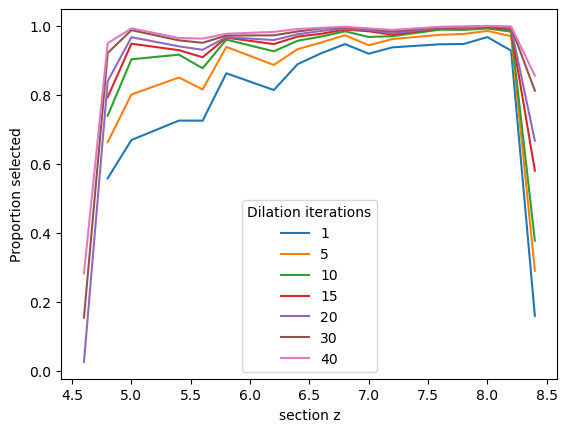

In [15]:
for i, xy in data.items():
    plt.plot(xy, label=i)

    # plt.ylim(0.2,1.1)
plt.ylabel('Proportion selected')
plt.xlabel('section z')
plt.legend(title='Dilation iterations')

Using a true dilation by radius takes much longer, doesn't look much different.

In [15]:
data = dict()
for radius in [1,5,10,15,20,30]:
    mask = sectionwise_dilation(th_mask, radius, true_radius=True)
    # mask = sectionwise_dilation(mask_img, distance_px, dilation_method='by_iteration')
    label_thalamus_masked_cells(cells_df, mask, coords, res)
    data[radius*0.01] = (cells_df.loc[cells_df['thal_subclass']]
        .groupby('z_reconstructed')['thal_dataset'].mean().loc[lambda x: x>0])

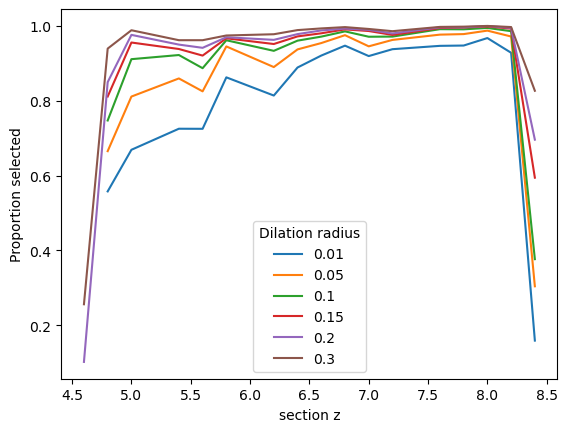

In [16]:
for i, xy in data.items():
    plt.plot(xy, label=i)

plt.ylabel('Proportion selected')
plt.xlabel('section z')
plt.legend(title='Dilation radius')

Note that the issues are primarily with the posterior sections.

Seems best to go with 10-15 iterations (100-150 um), but still isn't perfect.

Dropping sections 8.4 (not included previously) and 4.8 (included previously) seems safest for now (see plots below).

In [52]:
distance_px = 15
coords = np.mgrid[-distance_px:distance_px+1, -distance_px:distance_px+1]
struct = np.linalg.norm(coords, axis=0) <= distance_px

In [37]:
# mask = abc.sectionwise_dilation(th_mask, 15, dilation_method='by_iteration')
# coords = ['x_reconstructed','y_reconstructed','z_reconstructed']
# res = np.array([10e-3, 10e-3, 200e-3])
# abc.label_thalamus_masked_cells(cells_df, mask, coords, res)

### test end-to-end function

In [53]:
th_df = abc.label_thalamus_spatial_subset(cells_df, distance_px=10, filter_cells=True)

In [54]:
th_zi_sections = sorted(th_df['z_section'].unique())
th_zi_sections

[5.0,
 5.4,
 5.6000000000000005,
 5.800000000000001,
 6.2,
 6.4,
 6.6000000000000005,
 6.800000000000001,
 7.0,
 7.2,
 7.6,
 7.800000000000001,
 8.0,
 8.200000000000001]

In [55]:
th_zi_sections = sorted(th_df['z_reconstructed'].unique())
th_zi_sections

[5.0,
 5.4,
 5.6000000000000005,
 5.800000000000001,
 6.2,
 6.4,
 6.6000000000000005,
 6.800000000000001,
 7.0,
 7.2,
 7.6,
 7.800000000000001,
 8.0,
 8.200000000000001]

In [56]:
len(th_zi_sections)

14

In [ ]:
# th_classes = []
# classes_ind = sorted(cells_df['class'].unique())
# classes_ind

### visualize which cells are captured by the TH mask

In [57]:
def plot_th_mask_with_cell_overlay(cell_df, th_mask, th_zi_sections, 
                                   column='class'):

    # make a fixed colormap for displaying thalamus mask
    cmap_th_mask = colors.ListedColormap(['lightgrey', 'white'])
    bounds=[0,1]
    norm = colors.BoundaryNorm(bounds, cmap_th_mask.N)

    # define legend elements for the column colors
    color_col = column+'_color'
    categories = cell_df[column].unique()
    cat_color_mapping = dict(zip(categories, cell_df[color_col].unique()))
    # sort the dict & the categories list by category
    cat_color_mapping = dict(sorted(cat_color_mapping.items()))
    categories = sorted(categories)
    legend_elements = [Line2D([0], [0], 
                              lw=0, marker='o', markersize=10,
                              markerfacecolor=cat_color_mapping[cat],
                              color=cat_color_mapping[cat], 
                              label=cat) 
                       for cat in cat_color_mapping]
    
    n_col = 2
    n_row = int(np.ceil(len(th_zi_sections) / n_col))
    fig, axes = plt.subplots(n_row, n_col, figsize=(12,30))
    axes = axes.ravel()

    x_min = 2.5; x_max = 8.5; y_min = 7.5; y_max = 4

    for i, sec in enumerate(th_zi_sections):
        ax = axes[i]

        curr_sec_cell_df = cell_df[(cell_df['z_reconstructed']==sec)]

        ax.imshow(th_mask[:,:,int(sec/0.2)].T, extent=[0, 11, 11, 0], zorder=0,
                  cmap=cmap_th_mask, norm=norm)
        sc = ax.scatter(curr_sec_cell_df['x_reconstructed'], curr_sec_cell_df['y_reconstructed'],
                        color=curr_sec_cell_df['class_color'],
                        s=0.5, marker='.', zorder=1)
        ax.set_title('z='+str(sec))

        ax.set_xlim((x_min,x_max))
        ax.set_xlabel('x_reconstructed')
        ax.set_ylabel('y_reconstructed')
        ax.set_ylim((y_min,y_max))
        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])

        if i==7:
            ax.legend(legend_elements, categories, title='class', 
                      loc='center left', bbox_to_anchor=(1.1,0.5))

In [58]:
th_zi_sections = sorted(th_df['z_section'].unique())
th_zi_sections = sorted(cells_df['z_reconstructed'].unique())[19:35]
th_mask_dilated = abc.sectionwise_dilation(th_mask, 20)

In [59]:
nn_classes = ['30 Astro-Epen', '31 OPC-Oligo', '32 OEC', '33 Vascular', '34 Immune']
th_zi_classes = ['12 HY GABA', '13 CNU-HYa Glut','17 MH-LH Glut','18 TH Glut']

#### neuronal classes

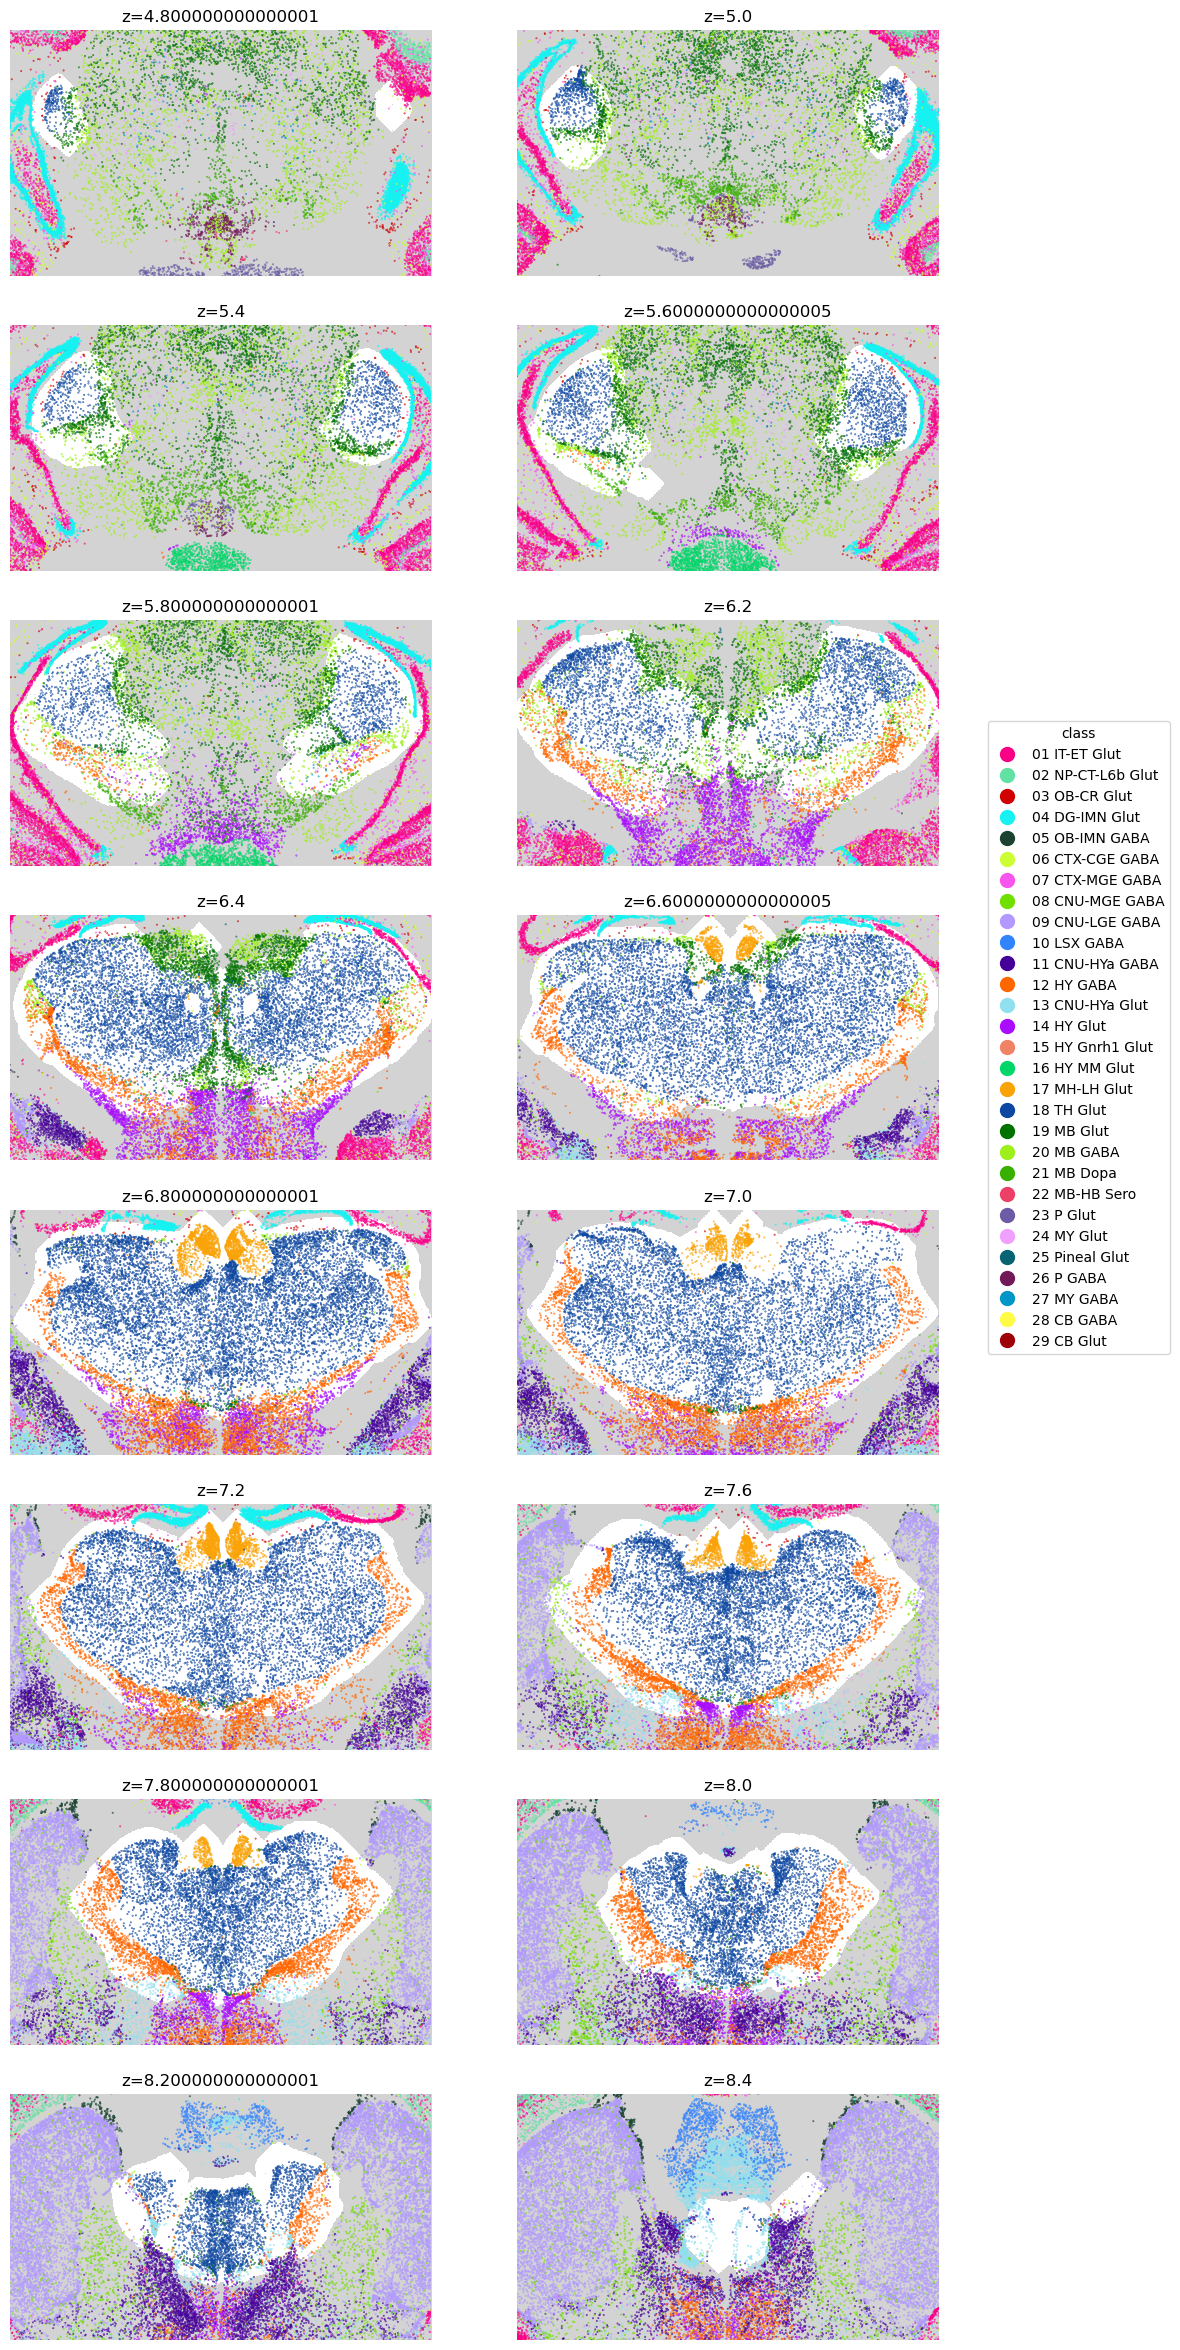

In [46]:
neuronal_cells_df = cells_df[(~cells_df['class'].isin(nn_classes))
                             & (cells_df['z_reconstructed'].isin(th_zi_sections))
                            ]  #& (cells_df['thal_subclass'])
plot_th_mask_with_cell_overlay(neuronal_cells_df, th_mask_dilated, th_zi_sections, column='class')

#### thalamus classes only

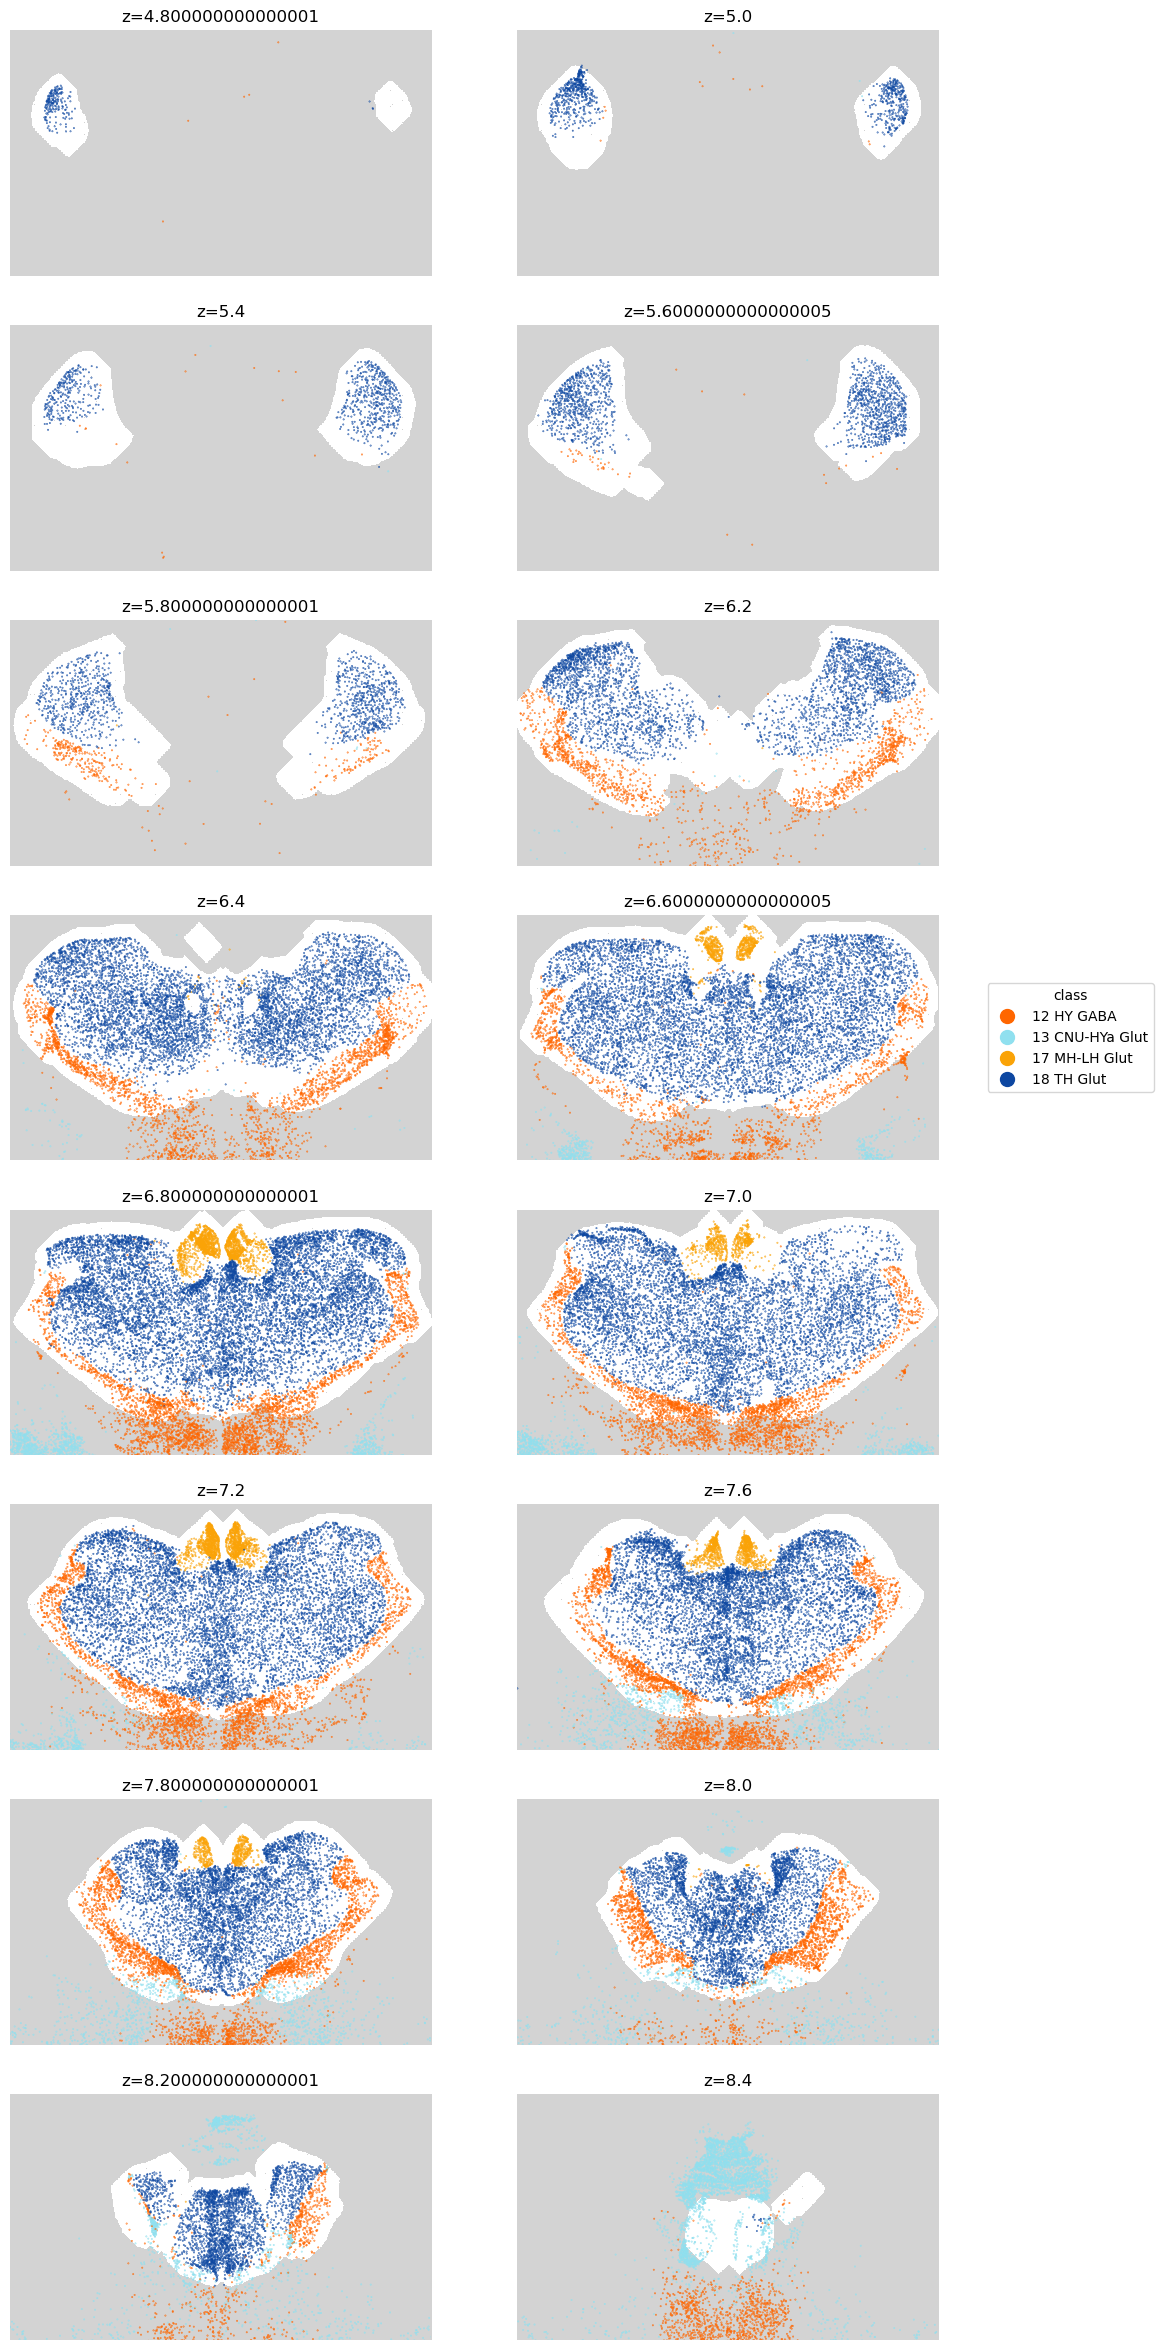

In [60]:
neuronal_th_cells_df = cells_df[(~cells_df['class'].isin(nn_classes))
                                & (cells_df['z_reconstructed'].isin(th_zi_sections))
                                & (cells_df['class'].isin(th_zi_classes))
                               ]  
plot_th_mask_with_cell_overlay(neuronal_th_cells_df, th_mask_dilated, th_zi_sections, column='class')

#### thalamus subclasses only

In [ ]:
neuronal_th_cells_df = cells_df[((~cells_df['class'].isin(nn_classes))
                                & (cells_df['z_reconstructed'].isin(th_zi_sections))
                                & (cells_df['thal_subclass'])
                               ]  
plot_th_mask_with_cell_overlay(neuronal_th_cells_df, th_mask_dilated, th_zi_sections, column='class')

### compare to Brian's outline dataset

In [ ]:
old_ids = abc.get_thalamus_reference_ids().intersection(cells_df.index)
new_ids = cells_df.query("thal_dataset").index

In [ ]:
len(old_ids.intersection(new_ids))

In [ ]:
len(new_ids.difference(old_ids))

In [ ]:
len(old_ids.difference(new_ids))

The new outline adds about 2% more new cells. Could also be worth checking on where the cells not in the old version are located...

In [ ]:
cells_df.loc[old_ids.difference(new_ids), 'z_reconstructed'].value_counts().sort_index()

In [ ]:
cells_df.loc[old_ids.difference(new_ids), 'subclass'].value_counts().head(10)

### examine end sections with poor match

In [ ]:
z = 8.4
plt.imshow(mask[:,:, int(z/0.2)].T, extent=[0, 11, 11, 0])
sns.scatterplot(data=cells_df.query(f"thal_subclass & z_reconstructed=={z}"), x=coords[0], y=coords[1])
plt.ylim(7, 5)
plt.xlim(4, 7)

In [ ]:
z = 4.8
plt.imshow(mask[:,:, int(z/0.2)].T, extent=[0, 11, 11, 0])
sns.scatterplot(data=cells_df.query(f"thal_subclass & z_reconstructed>{z-0.1} & z_reconstructed<{z+0.1}"), x=coords[0], y=coords[1], s=4)
plt.ylim(6, 4)
plt.xlim(2, 8)

In [ ]:
z = 5.6
plt.imshow(mask[:,:, int(z/0.2)].T, extent=[0, 11, 11, 0])
sns.scatterplot(data=cells_df.query(f"thal_subclass & z_reconstructed>{z-0.1} & z_reconstructed<{z+0.1}"), x=coords[0], y=coords[1], s=4)
# plt.ylim(7, 5)
# plt.xlim(4, 7)

## full 10um ccf

In [ ]:
# very slow to do operations with this large image volume

# ccf_img = abc.get_ccf_labels_image()
# # takes about 1 min
# th_mask = np.isin(ccf_img, th_zi_ind)

## mask into polygon

In [49]:
import skimage as ski

In [47]:
th_mask.shape[2]

76

In [48]:
th_zi_sections

[4.800000000000001,
 5.0,
 5.4,
 5.6000000000000005,
 5.800000000000001,
 6.2,
 6.4,
 6.6000000000000005,
 6.800000000000001,
 7.0,
 7.2,
 7.6,
 7.800000000000001,
 8.0,
 8.200000000000001,
 8.4]

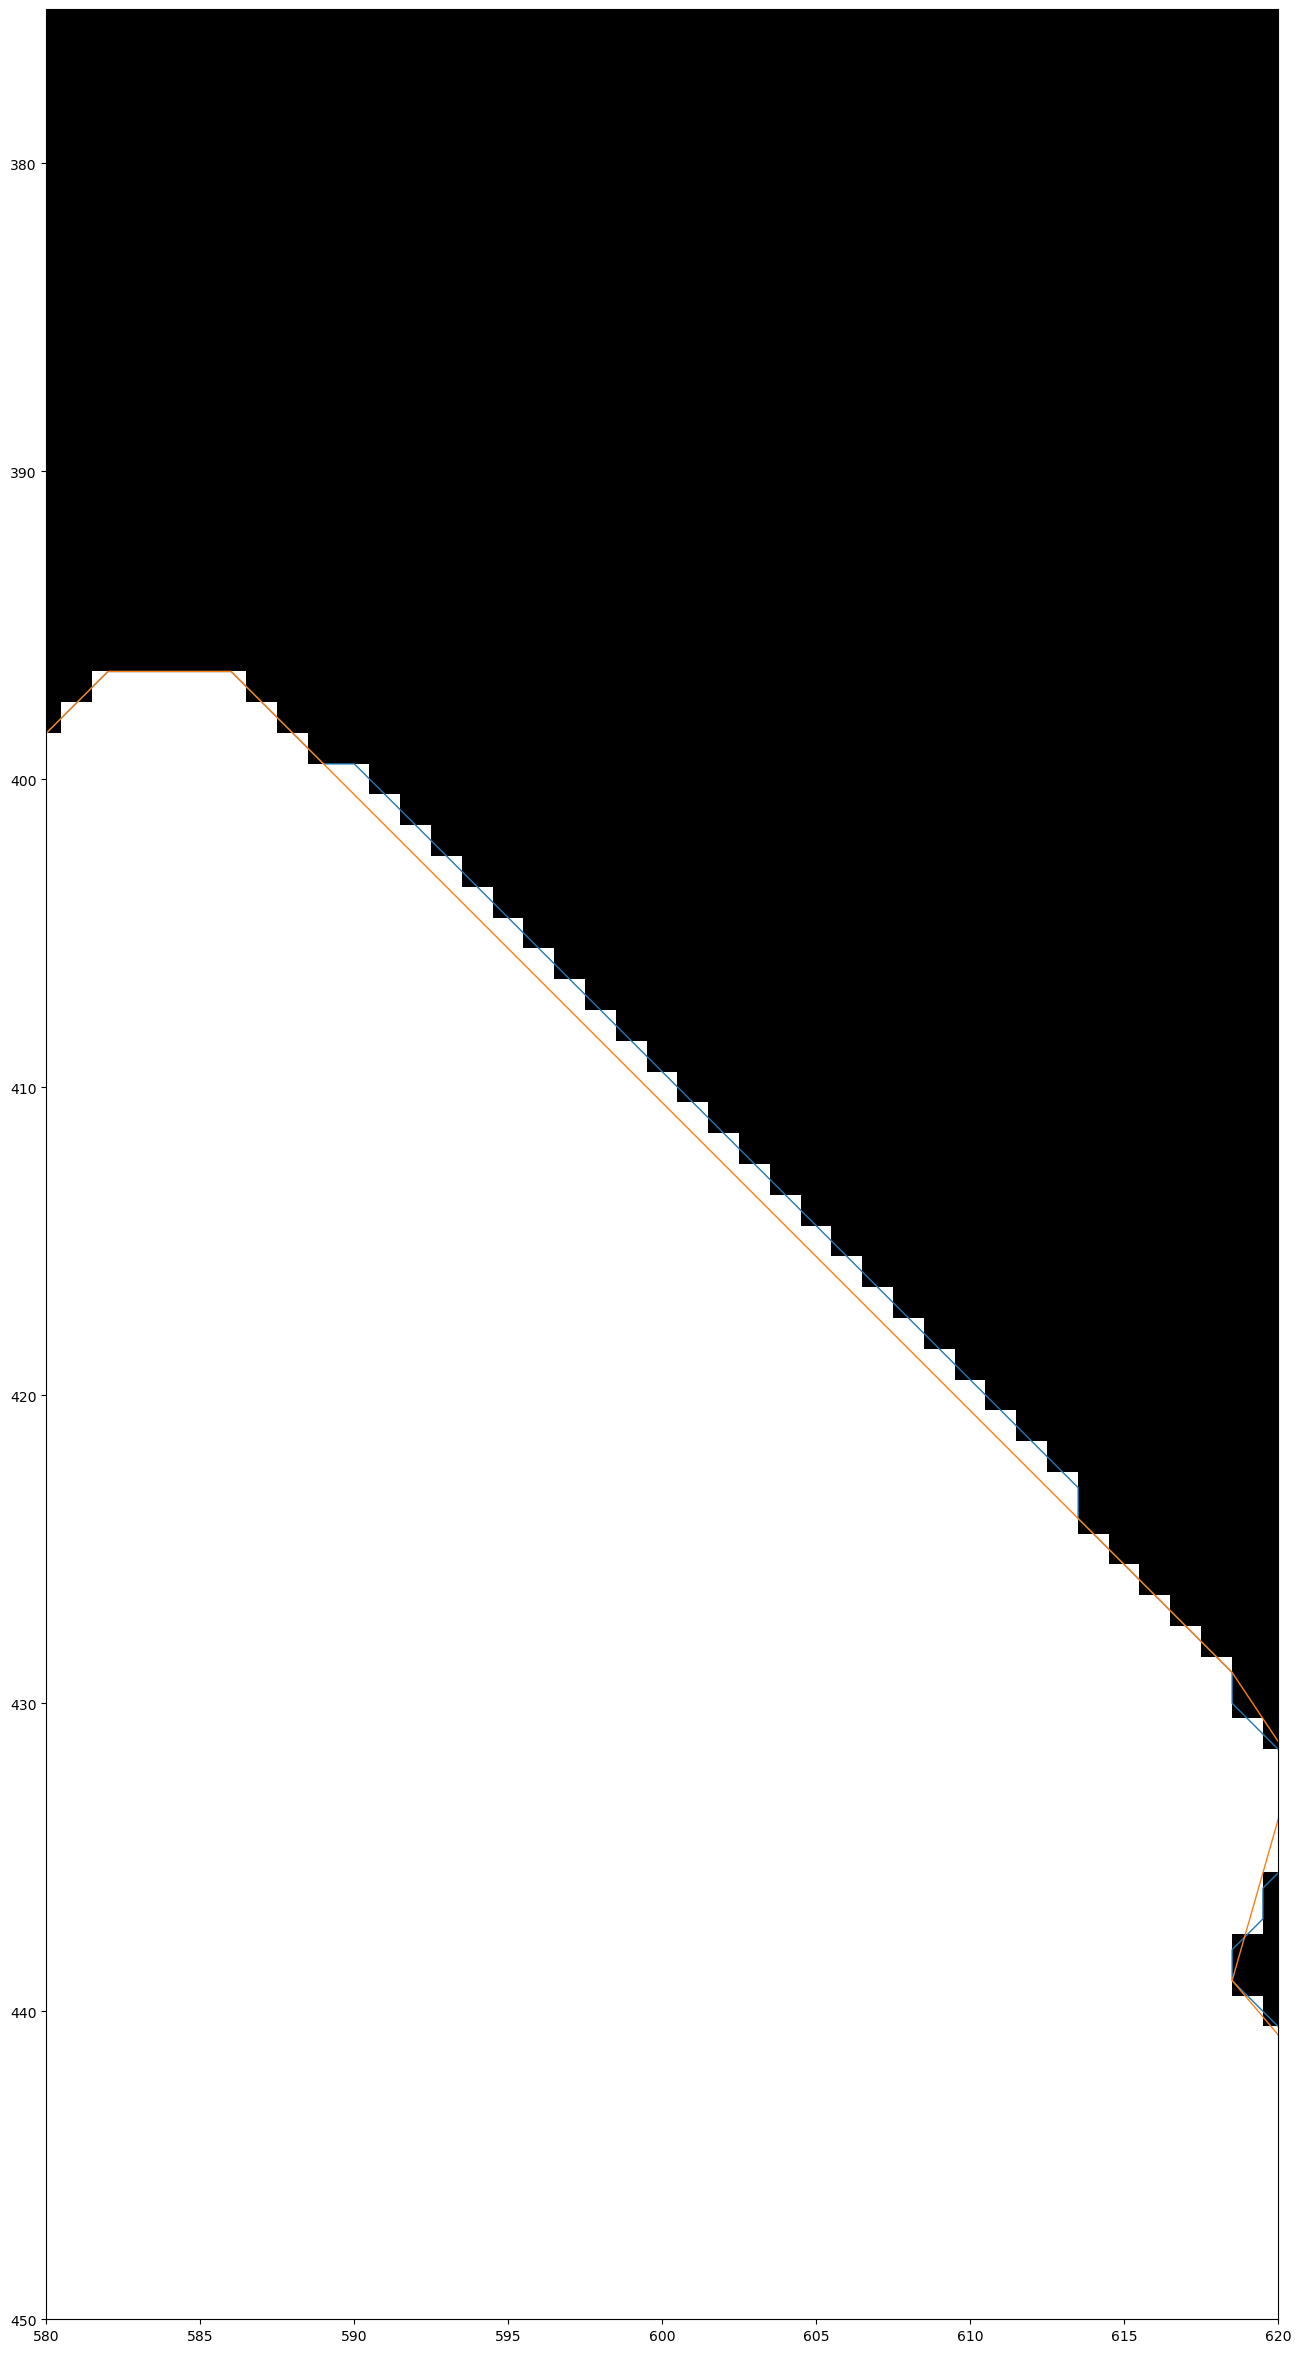

len(contour)=2087
len(coords)=110


In [94]:
z = th_zi_sections[7]
mask_ind = int(z/0.2)
ex_th_mask = np.squeeze(th_mask_dilated[:,:,mask_ind]).T

contours = ski.measure.find_contours(ex_th_mask)

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(20,30))
ax.imshow(ex_th_mask, cmap='gray')#, extent=(0,11,0,11))

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1)
    
    coords = ski.measure.approximate_polygon(contour, tolerance=1.0)
    ax.plot(coords[:, 1], coords[:, 0], linewidth=1)
    
ax.axis('image')
ax.set_xlim(250,900)
ax.set_ylim(750,375)
ax.set_xlim(580,620)
ax.set_ylim(450,375)
# ax.set_xticks([])
# ax.set_yticks([])
plt.show()

print(f'{len(contour)=}')
print(f'{len(coords)=}')

In [64]:
contours

[array([[599.5, 337. ],
        [599.5, 336. ],
        [599.5, 335. ],
        ...,
        [598.5, 338. ],
        [599. , 337.5],
        [599.5, 337. ]]),
 array([[585.5, 769. ],
        [585.5, 768. ],
        [585.5, 767. ],
        [585.5, 766. ],
        [585.5, 765. ],
        [585. , 764.5],
        [584.5, 764. ],
        [584.5, 763. ],
        [584.5, 762. ],
        [584. , 761.5],
        [583.5, 761. ],
        [583. , 760.5],
        [582.5, 760. ],
        [582. , 759.5],
        [581.5, 759. ],
        [581. , 758.5],
        [580.5, 758. ],
        [580. , 757.5],
        [579.5, 757. ],
        [579. , 756.5],
        [578.5, 756. ],
        [578. , 755.5],
        [577.5, 755. ],
        [577. , 754.5],
        [576.5, 754. ],
        [576. , 753.5],
        [575.5, 753. ],
        [575. , 752.5],
        [574.5, 752. ],
        [574. , 751.5],
        [573.5, 751. ],
        [573. , 750.5],
        [572.5, 750. ],
        [572. , 749.5],
        [571.5, 749. ],
 

In [ ]:
th_start_ind = int(th_zi_sections[0]/0.2)
th_end_ind = int(th_zi_sections[-1]/0.2)+1
th_mask_subset = th_mask_dilated[:,:,th_start_ind:th_end_ind]

th_mask_sobel_edge = np.zeros_like(th_mask_subset)

In [ ]:
n_col = 2
n_row = int(np.ceil(th_mask_subset.shape[2] / n_col))
fig, axes = plt.subplots(n_row, n_col, figsize=(12,30))
axes = axes.ravel()

x_min = 2.5; x_max = 8.5; y_min = 7.5; y_max = 4

for z in np.arange(th_mask_subset.shape[2]):
    ax = axes[z]
    ax.imshow(np.squeeze(th_mask_subset[:,:,z]).T,cmap='gray', extent=(0,11,0,11))
    ax.set_xlim(2.5,8.5)
    ax.set_ylim(4,7)
    # plt.xlim(3.8,4.2)
    # plt.ylim(4.5,5)

In [ ]:
n_col = 2
n_row = int(np.ceil(th_mask_subset.shape[2] / n_col))
fig, axes = plt.subplots(n_row, n_col, figsize=(12,30))
axes = axes.ravel()

x_min = 2.5; x_max = 8.5; y_min = 7.5; y_max = 4

for z in np.arange(th_mask_subset.shape[2]):
    sobel_edge = ski.filters.roberts(np.squeeze(th_mask_subset[:,:,z]))
    th_mask_sobel_edge[:,:,z] = sobel_edge

    ax = axes[z]
    ax.imshow(sobel_edge.T,cmap='gray', extent=(0,11,0,11))
    ax.set_xlim(2.5,8.5)
    ax.set_ylim(4,7)
    # plt.xlim(3.8,4.2)
    # plt.ylim(4.5,5)

## remove small mistake regions

In [16]:
dilated_th_mask = abc.sectionwise_dilation(th_mask, distance_px=20)

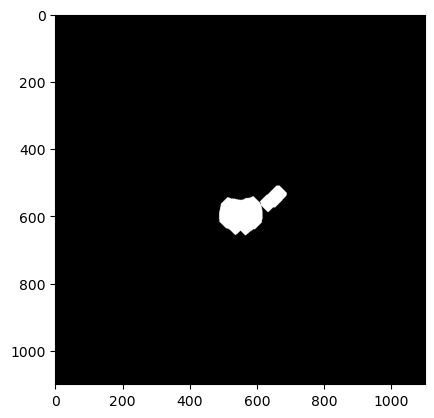

In [41]:
plt.imshow(dilated_th_mask[:,:,42].T,cmap='gray') #, extent=(0,11,0,11))

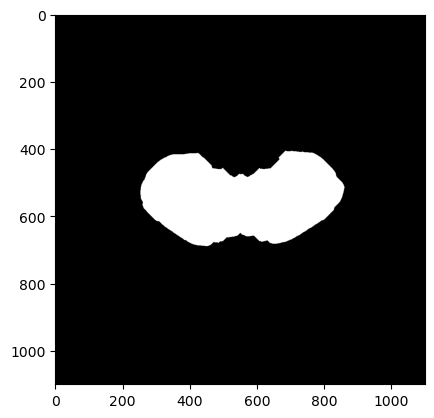

In [43]:
max_area_ratio=0.1
mask_img = dilated_th_mask[:,:,32]

labeled_mask, n_features = ndi.label(mask_img)

# calculate the area of the largest region
largest_region = np.argmax(ndi.sum(mask_img, labeled_mask, range(n_features + 1)))
largest_area = np.sum(labeled_mask==largest_region)

# filter out regions with area ratio smaller than the specified threshold
regions_to_keep = [label for label 
                   in range(1, n_features + 1) 
                   if np.sum(labeled_mask==label) / largest_area >= max_area_ratio
                  ]

# make a new mask with only the remaining objects
new_mask_img = np.isin(labeled_mask, regions_to_keep)

plt.imshow(new_mask_img.T,cmap='gray')

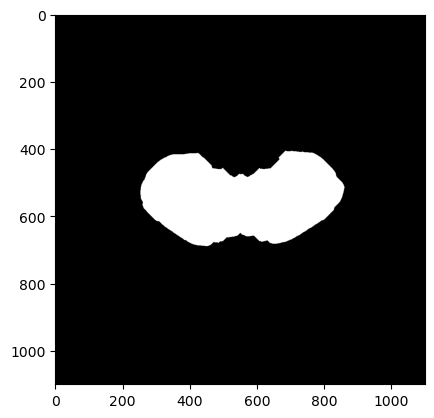

In [45]:
mask_img = dilated_th_mask

new_mask_img = np.zeros_like(mask_img)
for sec in range(mask_img.shape[2]):
    mask_2d = mask_img[:,:,sec]

    labeled_mask, n_regions = ndi.label(mask_2d)

    # calculate the area of the largest region
    largest_region = np.argmax(ndi.sum(mask_2d, labeled_mask, range(n_regions+1)))
    largest_area = np.sum(labeled_mask==largest_region)

    # filter out regions with area ratio smaller than the specified threshold
    regions_to_keep = [label for label 
                       in range(1, n_regions+1) 
                       if np.sum(labeled_mask==label) / largest_area >= max_area_ratio
                      ]
    # make a new mask with only the remaining objects
    new_mask_img[:,:,sec] = np.isin(labeled_mask, regions_to_keep)
    
plt.imshow(new_mask_img[:,:,32].T,cmap='gray')